sbatch SpikeCounter/cluster/run_array_autosegmentation.sh /n/holyscratch01/cohen_lab/bjia/20210724_gcamp_widefield/analysis/experiment_data.csv /n/holyscratch01/cohen_lab/bjia/20210724_gcamp_widefield/corrected 1 0 5 3 375 0.01 0.52 0.8 0.15 2.5

In [ ]:
import sys
sys.path.append("../SpikeCounter")
from spikecounter.analysis import traces, images
from spikecounter import utils
from spikecounter.ui import visualize

In [ ]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
from datetime import datetime
import scipy.signal as signal
import scipy.stats as stats
import scipy.interpolate as interpolate
import scipy.optimize as optimize
from scipy.ndimage.filters import uniform_filter1d
import matplotlib.lines as mlines
import matplotlib.colors as colors
import seaborn as sns
import os
from scipy.io import savemat
from skimage import transform, measure
import skimage.io as skio
import importlib
plt.style.use("../bio_pubs_presentation.mplstyle")

In [2]:
importlib.reload(visualize)
importlib.reload(images)
importlib.reload(traces)

NameError: name 'importlib' is not defined

In [ ]:
rootdir = "/n/holyscratch01/cohen_lab/bjia/20210724_gcamp_widefield/corrected"

PCA causes distortion of low SNR signals.

In [5]:
fs=10.2
start_hpf = 19
expt_info = utils.process_experiment_metadata(pd.read_csv(os.path.join(rootdir,"analysis/experiment_data.csv")))
expt_info["hpf"] = start_hpf + expt_info["offset"]/3600

### Load segmented traces

In [2]:
segmentation_mask = skio.imread(os.path.join(rootdir, "analysis/unlinked_segmentation_video.tif"))
roi_map = np.median(segmentation_mask, axis=0)
roi_map = roi_map[np.arange(roi_map.shape[0], step=2),:]
roi_map = roi_map[:,np.arange(roi_map.shape[1], step=2)]
plt.imshow(roi_map)

NameError: name 'skio' is not defined

In [7]:
dobj = traces.TimelapseArrayExperiment(os.path.join(rootdir, "analysis"),start_hpf, fs)

In [8]:
def custom_lp_filter(raw, norm_thresh=0.8):
    sos = signal.butter(5, norm_thresh,output="sos")
    intensity = signal.sosfiltfilt(sos, raw)
#     mean_freq = 2.0
#     b, a = signal.butter(5, [mean_freq-0.2, mean_freq+0.2], btype="bandstop", fs=10.2)
#     intensity = signal.filtfilt(b, a, intensity)
    return intensity

In [9]:
with open(os.path.join(rootdir, "analysis", "usable_files.pickle"), "rb") as f:
    usable_files = pickle.load(f)

In [10]:
usable_indices = []
for fname in usable_files:
    contains_file = expt_info["file_name"].str.contains(fname).to_numpy()
    usable_indices.append(np.argwhere(contains_file).ravel()[0])
usable_indices = np.array(usable_indices)

In [11]:
dobj.load_traces(timepoints=usable_indices, per_trace_start=0, corr_photobleach=False, filter_function=lambda x: x)

In [1]:
dobj.analyze_peaks(threshold="auto", prominence="snr", auto_prom_scale=3, auto_thresh_scale=0.4, \
                   wlen=20, min_width=2, max_width=30, baseline_duration=3000, baseline_start=15000,\
                  excl=1000)

NameError: name 'dobj' is not defined

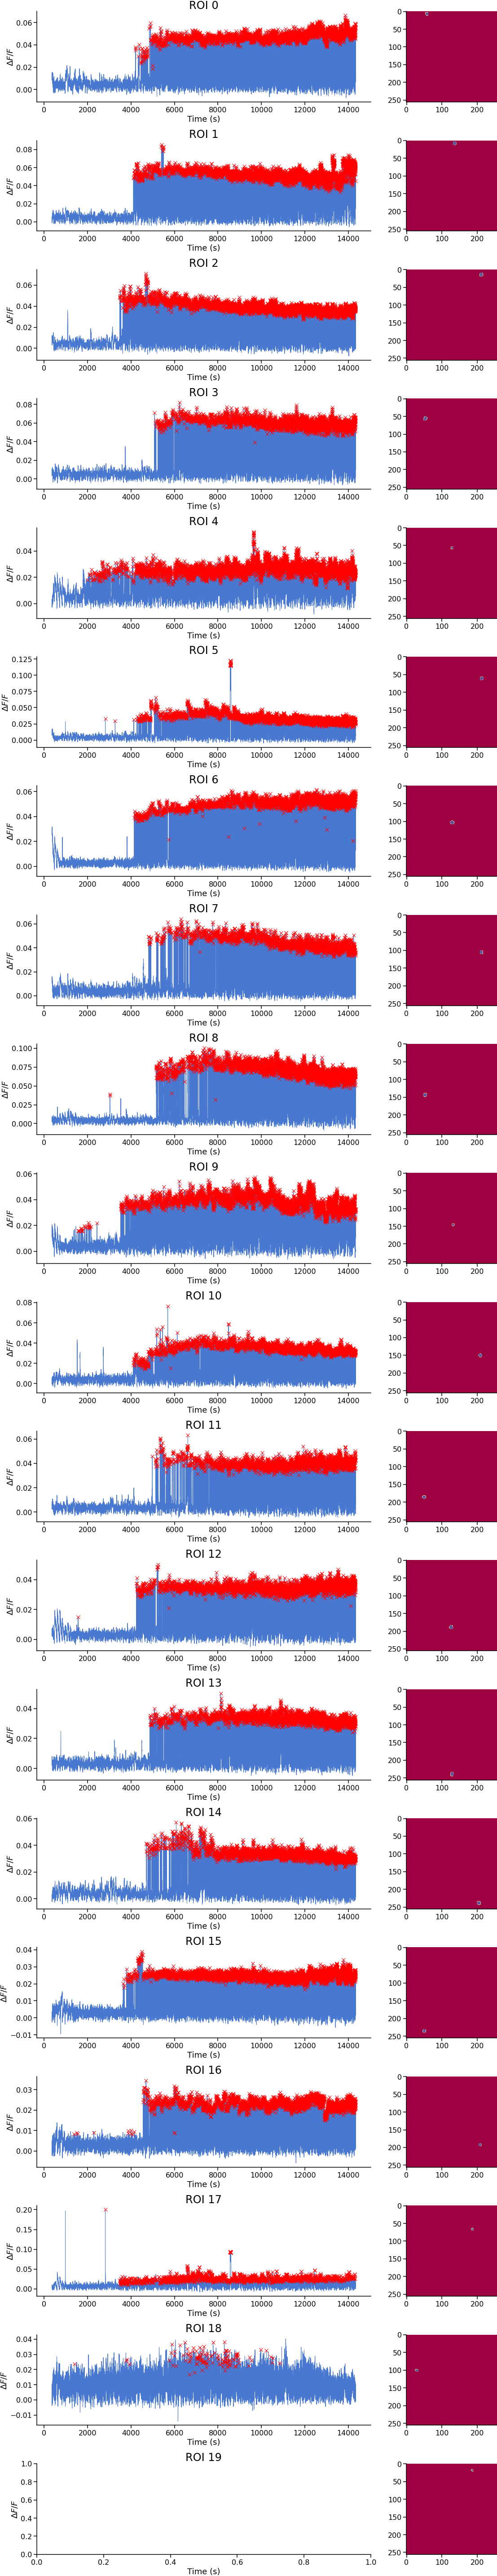

In [13]:
plt.close("all")
fig1, axes = dobj.plot_spikes_with_mask(roi_map)
plt.savefig(os.path.join(rootdir, "analysis", "spikeplots.svg"))

(340.0, 940.0)

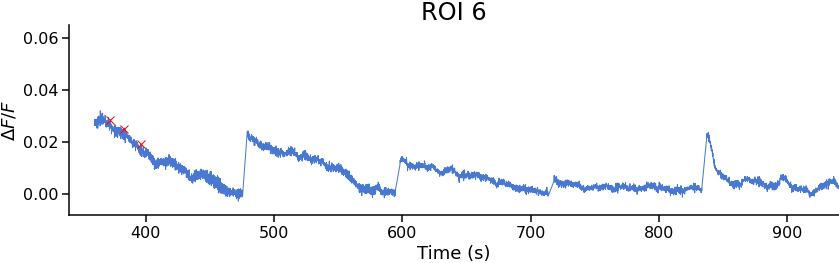

In [23]:
roi=6
fig1, ax1 = dobj.plot_spikes([roi])
window = 600
start = 340
ax1[0].set_xlim(start, start+window)

In [41]:
start_idx = np.argwhere(dobj.t>start).ravel()[0]
end_idx = np.argwhere(dobj.t> (start+window)).ravel()[0]

In [42]:
dobj.dFF.shape

(20, 142539)

In [43]:
test_data = dobj.dFF[roi][start_idx:end_idx]
test_data2 =dobj.dFF[roi, 100000:100000+window*10]

In [44]:
prominence=0.0035307264955225515
height=0.0188936280684372
wlen=20
min_width=2
rel_height=0.5
max_width=30

In [45]:
pks1, props1 = signal.find_peaks(test_data, prominence = prominence, height=height, wlen=wlen, width=(min_width,max_width), rel_height=rel_height)
pks2, props2 = signal.find_peaks(test_data2, prominence = prominence, height=height, wlen=wlen, width=(min_width,max_width), rel_height=rel_height)

In [46]:
props1

{'peak_heights': array([0.02838873]),
 'prominences': array([0.00400786]),
 'left_bases': array([120]),
 'right_bases': array([136]),
 'widths': array([4.2249345]),
 'width_heights': array([0.0263848]),
 'left_ips': array([126.08507233]),
 'right_ips': array([130.31000683])}

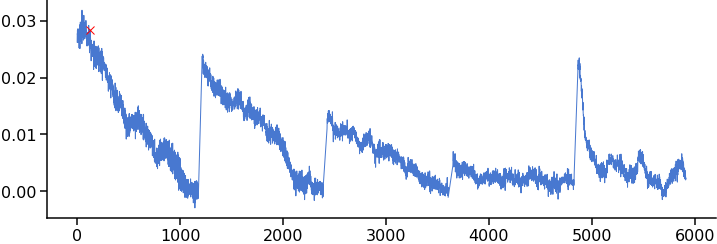

In [47]:
fig1, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(test_data)
ax1.plot(pks1, test_data[pks1], "rx")
# ax1.set_xlim(pks1[0]-20, pks1[0]+20)
# ax1.plot(test_data2)
# ax1.plot(pks2, test_data2[pks2], "gx")
# ax1.set_xlim(664, 677)

## Align embryos according to time of first spike

First try criterion based on interspike intervals

In [14]:
offset_times = []
isi_threshold = 30
rois = dobj.peaks_data.index.unique()[:17]
for idx, roi in enumerate(rois):
    roi_data = dobj.peaks_data.loc[roi]
#     print(roi_data["isi"].to_numpy() < isi_threshold)
    isi = roi_data["isi"].to_numpy()
    offset_idx = np.argwhere((isi< isi_threshold)&(np.roll(isi, 1) < isi_threshold)).ravel()[0]
    offset_times.append(roi_data["t"].iloc[offset_idx])

In [15]:
dobj.peaks_data.loc[rois].to_csv(os.path.join(rootdir, "analysis", "peaks_data.csv"))

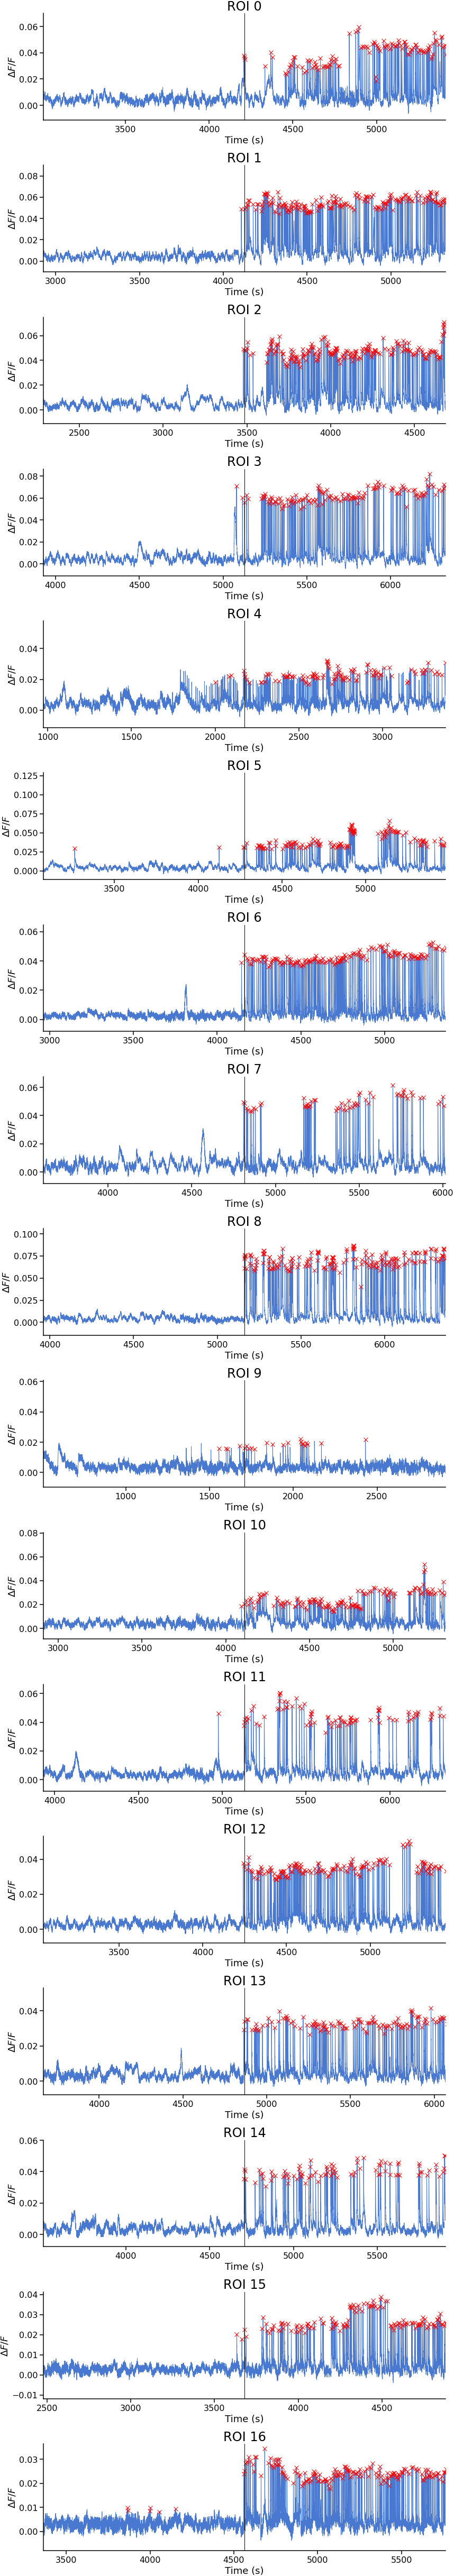

In [26]:
fig1, axes = dobj.plot_spikes(rois)
half_window = 1200
for idx, roi in enumerate(rois):
    axes[idx].set_xlim((offset_times[idx]-half_window, offset_times[idx]+half_window))
    axes[idx].axvline(offset_times[idx], color="black")

### Check frequency change over developmental time for selected embryos

In [17]:
window_size=1800

In [18]:
droi, dsta, dststd = dobj.get_windowed_peak_stats(window_size, overlap=0.9, sta_bounds=None, isi_stat_min_peaks=6)

Text(0, 0.5, 'Mean spike frequency (Hz)')

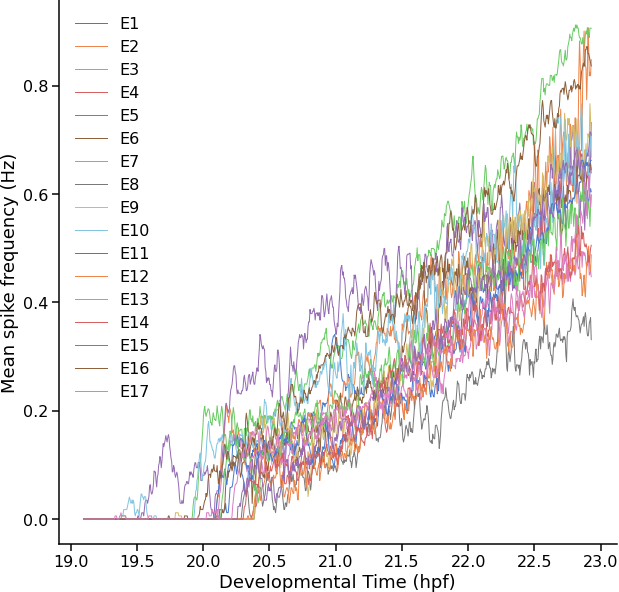

In [19]:
fig1, ax1 = plt.subplots(figsize=(10,10))
for roi in rois:
    e_data = droi.loc[roi]
    ax1.plot(e_data["hpf"], e_data["mean_freq"], label= "E%d" % (roi+1))
ax1.legend()
ax1.set_xlabel("Developmental Time (hpf)")
ax1.set_ylabel("Mean spike frequency (Hz)")

(16000.0, 16100.0)

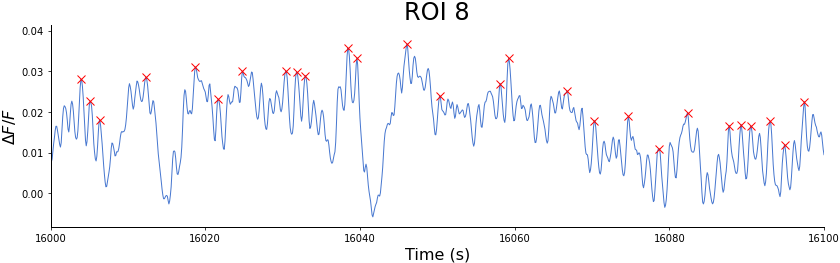

In [83]:
fig1, ax1 = dobj.plot_spikes([8])
window = 100
start = 16000
ax1[0].set_xlim(start, start+window)

In [617]:
expt_info[expt_info["offset"]>start].iloc[0]

start_time               08:16:56
file_name     081656_p1_t43_p1_z1
offset                       5016
hpf                     20.393333
Name: 42, dtype: object

Align by offset

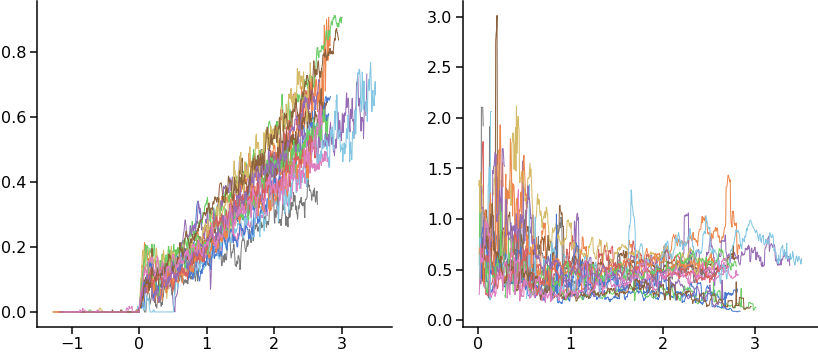

In [20]:
b, a = signal.butter(11, 0.07)
fig1, axes = plt.subplots(1,2, figsize=(14,6))
for idx, roi in enumerate(rois):
    e_data = droi.loc[roi]
    mean_freq = np.array(e_data["mean_freq"])
    hpf = np.array(e_data["hpf"])
    cov = np.array(e_data["std_isi"]/e_data["mean_isi"])

    hpf_offset = dobj.start_hpf + offset_times[idx]/3600 - 0.05
    
    axes[0].plot(e_data["hpf"]-hpf_offset, mean_freq)
    axes[1].plot(e_data["hpf"]-hpf_offset, cov)
#     ax1.plot(e_data["hpf"]-hpf_offset, smoothed_mean_freq, label= "E%d" % (roi+1))

This one performs better I think.

In [21]:
all_offsets = []
for idx, roi in enumerate(rois):
    e_data = droi.loc[roi]
    hpf = np.array(e_data["hpf"])
    all_offsets.append(np.argwhere(e_data["offset"].to_numpy() >= offset_times[idx]).ravel()[0])

/tmp/ipykernel_101010/3612582612.py:32: RuntimeWarning: Mean of empty slice
  axes[0].plot(np.nanmean(aligned_frequencies, axis=0))
/tmp/ipykernel_101010/3612582612.py:33: RuntimeWarning: Mean of empty slice
  axes[1].plot(np.nanmean(aligned_covs, axis=0))
/tmp/ipykernel_101010/3612582612.py:36: RuntimeWarning: Mean of empty slice
  "mean_freq": np.nanmean(aligned_frequencies, axis=0), "hpf":hpf, \


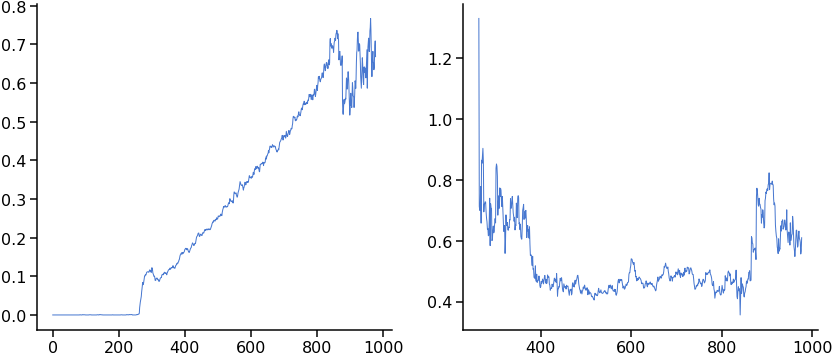

In [22]:
hpf = np.array(droi.loc[0]["hpf"])
hpf_offsets = hpf[all_offsets]
aligned_frequencies = np.nan*np.ones((len(rois), \
                                      hpf.shape[0]+max(all_offsets)))
aligned_proms = np.zeros((len(rois), hpf.shape[0]+max(all_offsets)))
aligned_covs = np.nan*np.ones((len(rois), \
                                      hpf.shape[0]+max(all_offsets)))
unaligned_frequencies = np.zeros((len(rois), hpf.shape[0]))
unaligned_covs = np.zeros((len(rois), hpf.shape[0]))
unaligned_proms = np.zeros((len(rois), hpf.shape[0]))
curr_row = 0
for roi in rois:
        e_data = droi.loc[roi]
        mean_freq = np.array(e_data["mean_freq"])
        cov = np.array(e_data["std_isi"]/e_data["mean_isi"])
        mean_prom = np.array(e_data["mean_prom"])
#         print(mean_freq.shape)
#         mean_freq = signal.filtfilt(b,a, mean_freq)
        start_idx = aligned_frequencies.shape[1] - e_data["hpf"].shape[0] - all_offsets[curr_row]
        
        unaligned_frequencies[curr_row, :] = mean_freq
        unaligned_proms[curr_row, :] = mean_prom
        unaligned_covs[curr_row,:] = cov
        
        aligned_frequencies[curr_row, start_idx:start_idx+e_data["hpf"].shape[0]] = \
            mean_freq
        aligned_proms[curr_row, start_idx:start_idx+e_data["hpf"].shape[0]] = mean_prom
        aligned_covs[curr_row, start_idx:start_idx+e_data["hpf"].shape[0]] = cov
        
        curr_row +=1
fig1, axes = plt.subplots(1,2, figsize=(14,6))
axes[0].plot(np.nanmean(aligned_frequencies, axis=0))
axes[1].plot(np.nanmean(aligned_covs, axis=0))
savemat(os.path.join(rootdir, "analysis", "all_moments.mat"), {"idx_offsets": all_offsets, \
            "all_freqs":unaligned_frequencies, "all_freqs_aligned":aligned_frequencies, \
            "mean_freq": np.nanmean(aligned_frequencies, axis=0), "hpf":hpf, \
            "proms": unaligned_proms, "proms_aligned": aligned_proms, "covs":unaligned_covs, "covs_aligned": aligned_covs})

In [27]:
savemat(os.path.join(rootdir, "analysis", "dFFs.mat"), {"rois": list(rois), "offset_times": offset_times, "f_s": fs, "dFF": dobj.dFF[rois,:], "t": dobj.t})

In [24]:
hpf_new = np.array(droi.loc[1]["hpf"])
edata = droi.loc[1]
new_offsets = [np.argwhere(hpf_new>=hpf_offsets[i])[0][0] for i in range(len(hpf_offsets))]
aligned_cov = np.nan*np.ones((len(rois), \
                                      edata["hpf"].shape[0]+max(new_offsets)))
unaligned_cov = np.zeros((len(rois), edata["hpf"].shape[0]))
curr_row = 0
print(aligned_cov.shape)
print(unaligned_cov.shape)
for roi in rois:
        e_data = droi.loc[roi]
        cov = np.array(e_data["std_isi"]/e_data["mean_isi"])
        start_idx = aligned_cov.shape[1] - e_data["hpf"].shape[0] - new_offsets[curr_row]
        aligned_cov[curr_row, start_idx:start_idx + e_data["hpf"].shape[0]] = \
            cov
        unaligned_cov[curr_row,:] = cov
        curr_row +=1

(17, 1055)
(17, 782)


In [25]:
savemat(os.path.join(rootdir, "analysis", "expt_cov.mat"), {"unaligned_cov": unaligned_cov, "aligned_cov":aligned_cov, "hpf_cov": hpf_new, "mean_cov": np.nanmean(aligned_cov, axis=0), "idx_offsets": new_offsets})

/tmp/ipykernel_101010/1346554861.py:1: RuntimeWarning: Mean of empty slice
  savemat(os.path.join(rootdir, "analysis", "expt_cov.mat"), {"unaligned_cov": unaligned_cov, "aligned_cov":aligned_cov, "hpf_cov": hpf_new, "mean_cov": np.nanmean(aligned_cov, axis=0), "idx_offsets": new_offsets})


### Check relative amplitude of spikes

In [140]:
droi

,mean_isi,std_isi,mean_prom,std_prom,mean_width,std_width,n_peaks,pct95_dff,pct5_dff,max_dff,min_dff,offset,hpf,mean_freq
roi,,,,,,,,,,,,,,
0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,19.000000,0.000000
0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,11.764706,19.003268,0.000000
0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,23.529412,19.006536,0.000000
0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,35.294118,19.009804,0.000000
0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,47.058824,19.013072,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15.0,5.382353,3.438354,0.012324,0.002392,0.861379,0.464429,20.0,0.016077,0.009421,0.018353,0.009175,14164.705882,22.934641,0.178791
15.0,4.789916,3.331999,0.012434,0.002463,0.907640,0.457646,21.0,0.015957,0.009434,0.018353,0.009175,14176.470588,22.937908,0.187730
15.0,4.781640,3.268336,0.012664,0.002759,1.001558,0.661748,22.0,0.018216,0.009597,0.020122,0.009175,14188.235294,22.941176,0.196670


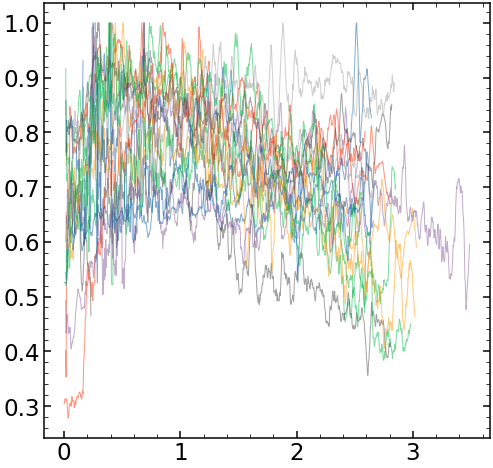

In [156]:
fig1, ax1 = plt.subplots(figsize=(8, 8))
for idx, roi in enumerate(rois):
    roi_data = droi.loc[roi]
    hpf_offset = dobj.start_hpf + offset_times[idx]/3600 - 0.05
    rel_prom = roi_data["mean_prom"].to_numpy()/np.nanmax(roi_data["mean_prom"])
#     print(rel_prom.shape)
#     print(roi_data["hpf"].shape)
#     print(hpf_offset.shape)
    hours = roi_data["hpf"].to_numpy() - hpf_offset
    idx_offset = np.argwhere(hours >= 0).ravel()[0]
    ax1.plot(hours[idx_offset:], rel_prom[idx_offset:], alpha=0.5)